We choose the kaggle platform to finetune the pre-trained model(Qwen3-0.6B-Base). After we pack our code up as a dataset and upload it to the kaggle platform. We Import the required dependencies and download the necessary packages.

In [7]:
# NOTE: Make sure you have added the dataset into the notebook
# Move the code to working directory
!mkdir /kaggle/working/src
!cp -r /kaggle/input/p2training/* /kaggle/working/src

# install necessary packages, as Kaggle will clear installed packages when restart the kernel.
%pip install torch numpy pandas transformers peft pyarrow pybind11 pylatexenc datasets tiktoken wandb tqdm matplotlib math-verify[antlr4_9_3]
%pip install --upgrade --force-reinstall scikit-learn
!pip install "numpy<2" "matplotlib<3.9" --force-reinstall -q
%cd /kaggle/working/src/p2
!ls

mkdir: cannot create directory ‘/kaggle/working/src’: File exists
Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_learn-1.7.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.16.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached numpy-2.3.5-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.9 MB)
Using cached scipy-1.16.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.9 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting unins

In the prepare.py, we apply chat-template and apply tokenization to the training dataset.

In [8]:
%cd /kaggle/working/src/p2/src
!ls
!python prepare.py # prepare data firstly, remove --debug for full data

/kaggle/working/src/p2/src
data	     finetune1.py  plot.py     rollout.py  verifier
evaluate.py  finetune.py   prepare.py  saves	   vllm_rollout.py
Loading tokenizer: 'Qwen/Qwen3-0.6B-Base'
Loading dataset: 'ricdomolm/MATH-500'
Dataset split into 10800 training and 1200 validation examples.

Tokenizing and formatting datasets...
Final training samples: 9114
Final validation samples: 1024

--- DATASET STATS ---
Sample of first training example:
 <|im_start|>user
Let $f$ be a linear function with the properties that $f(1) \le
f(2)$, $f(3) \ge f(4)$, and $f(5) = 5$.  Which of the following statements is true?

A) $f(0) < 0$

B) $f(0) = 0$

C) $f(1) < f(0) < f(-1)$

D) $f(0) = 5$

E) $f(0) > 5$Please reason step by step, and put your final answer withinoxed{}.<|im_end|>
<|im_start|>assistant
<think>

</think>

Since $f$ is a linear function, it has the form $f(x) = mx + b$. Because $f(1) \le f(2)$, we have $m
\ge 0$.  Similarly, $f(3) \ge f(4)$ implies $m \le 0$. Hence, $m = 0$, and $f$ is

Here is how we finetune the pre-trained model. We use SGD with Momentum + Nesterov + Weight Decay + Warmup + Cosine Annealing to finetune the pretrained-model. We also tried different learning rate to obtain several outputs. We write some code to record the training loss and the validation loss in case of plotting loss curve figure in the future. We record the time and the allocated memory that the training costs.

In [9]:
%%writefile /kaggle/working/src/p2/src/finetune.py


import os
import pickle
import argparse
import csv
import time
from tqdm import tqdm

import torch
import torch.optim as optim
import numpy as np
import random
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)
from peft import LoraConfig, get_peft_model

from torch.optim.lr_scheduler import CosineAnnealingLR

from transformers import get_linear_schedule_with_warmup

from transformers import get_cosine_schedule_with_warmup


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


def get_args():
    """Defines and parses command-line arguments."""
    parser = argparse.ArgumentParser(description="Fine-tune a language model.")

    # Model and Data paths
    parser.add_argument('--model_name', type=str, default='Qwen/Qwen3-0.6B-Base', help='The name of the pretrained model to use.')
    parser.add_argument('--data_dir', type=str, default='data', help='Directory where the data is stored.')
    parser.add_argument('--output_dir', type=str, default='out-instruction-tuning', help='Directory to save the fine-tuned model.')

    # Training Hyperparameters
    parser.add_argument('--num_epochs', type=int, default=1, help='Number of training epochs.')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate for the optimizer.')
    parser.add_argument('--weight_decay', type=float, default=0.01, help='Weight decay for the optimizer.')
    parser.add_argument('--beta1', type=float, default=0.9, help='AdamW optimizer beta1.')
    parser.add_argument('--beta2', type=float, default=0.95, help='AdamW optimizer beta2.')
    parser.add_argument('--batch_size', type=int, default=2, help='Batch size for training and validation.')
    parser.add_argument('--grad_accumulation_steps', type=int, default=4, help='Number of steps to accumulate gradients.')

    # Logging and Evaluation
    parser.add_argument('--log_interval', type=int, default=10, help='Log training loss every N steps.')
    parser.add_argument('--eval_interval', type=int, default=50, help='Run validation every N steps.')

    # Optimization method
    parser.add_argument('--optimization_method', type=str, default='adam', choices=['adam', 'sgd', 'lora'], help='Optimization method to use.')

    parser.add_argument('--lora_rank', type=int, default=8, help='The rank of the LoRA matrices.')

    return parser.parse_args()

class TokenizedDataset(Dataset):
    """A simple dataset class to load tokenized IDs from a pickle file."""
    def __init__(self, pickle_file_path):
        if not os.path.exists(pickle_file_path):
            raise FileNotFoundError(
                f"Pickle file not found at {pickle_file_path}. "
                "Please run the data preparation script first."
            )
        with open(pickle_file_path, 'rb') as f:
            self.data = pickle.load(f)
        print(f"Loaded {len(self.data)} examples from {pickle_file_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class SmartDataCollator:
    """
    Pads sequences to the max length in a batch and creates labels.
    Labels are -100 for pad tokens.
    """
    def __init__(self, pad_token_id):
        self.pad_token_id = pad_token_id

    def __call__(self, batch):
        input_ids = [torch.tensor(item['input_ids']) for item in batch]
        attention_masks = [torch.tensor(item['attention_mask']) for item in batch]
        labels = [torch.tensor(item['labels']) for item in batch]

        padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.pad_token_id)
        padded_attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=-100)

        return {
            'input_ids': padded_input_ids,
            'attention_mask': padded_attention_masks,
            'labels': padded_labels
        }

# 记录训练损失和验证损失
train_loss_log = []
val_loss_log = []

# 记录开始时间
start_time = time.time()

def main():
    args = get_args()

    # Derived paths
    current_file_path = os.path.abspath(__file__)
    script_dir = os.path.dirname(current_file_path)
    data_dir = os.path.join(script_dir, args.data_dir)
    train_data_path = os.path.join(data_dir, 'train.pkl')
    val_data_path = os.path.join(data_dir, 'val.pkl')
    output_dir = os.path.join(script_dir, args.output_dir)


    print(f"Loading model and tokenizer from {args.model_name}...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float32

    tokenizer = AutoTokenizer.from_pretrained(args.model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name,
        trust_remote_code=True,
        torch_dtype=dtype
    ).to(device)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id
        print("Set pad_token to eos_token")

    collate_fn = SmartDataCollator(pad_token_id=tokenizer.pad_token_id)

    train_dataset = TokenizedDataset(train_data_path)
    val_dataset = TokenizedDataset(val_data_path)

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        collate_fn=collate_fn,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        collate_fn=collate_fn
    )

    print(f"Setting up optimizer: {args.optimization_method}")

    # TODO: Apply different optimizer
    if args.optimization_method == "adam":
        optimizer = optim.Adam(
            model.parameters(),
            lr=args.learning_rate,
            weight_decay=args.weight_decay,
            betas=(args.beta1, args.beta2)
        )
    elif args.optimization_method == "sgd":
        args.learning_rate = 1e-4 
        args.weight_decay = 0.001
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.learning_rate,
            weight_decay=args.weight_decay,
            momentum = 0.9, # 添加动量
            nesterov = True # 开启Nesterov动量
        )
        total_steps = args.num_epochs * len(train_loader)
        warmup_steps = int(0.1 * total_steps) # 10%用于warmup
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, 
            num_warmup_steps = warmup_steps, 
            num_training_steps = total_steps
        )
    elif args.optimization_method == "lora":
        print(f"Setting up LoRA with rank={args.lora_rank}")
        lora_config = LoraConfig(
            r=args.lora_rank,
            lora_alpha=args.lora_rank * 2,
            bias="none",
            lora_dropout=0.05,
            task_type="CAUSAL_LM",
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], # Apply Lora to all possible modules
        )
        model = get_peft_model(model, lora_config)
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(
            trainable_params,
            lr=args.learning_rate,
            weight_decay=args.weight_decay,
            betas=(args.beta1, args.beta2)
        )
    else:
        raise ValueError(f"Unknown optimization_method: {args.optimization_method}")

    print("Starting training...")
    best_val_loss = float('inf')
    global_step = 0
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for epoch in range(args.num_epochs):
        print(f"\n--- Epoch {epoch+1}/{args.num_epochs} ---")
        model.train()
        for step, batch in enumerate(tqdm(train_loader, desc="Training")):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.autocast(device_type=device, dtype=dtype):
                outputs = model(**batch)
                loss = outputs.loss
            loss = loss / args.grad_accumulation_steps
            loss.backward()
            if (step + 1) % args.grad_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1
                scheduler.step() # 更新学习率
                if global_step % args.log_interval == 0:
                    train_loss_log.append({
                        "step":global_step,
                        "loss":loss.item() * args.grad_accumulation_steps
                    })
                    print(f"Step {global_step}: Train Loss = {loss.item() * args.grad_accumulation_steps:.4f}")
                if global_step % args.eval_interval == 0:
                    model.eval()
                    print("\nRunning validation...")
                    total_val_loss = 0
                    with torch.no_grad():
                        for val_batch in tqdm(val_loader, desc="Validating"):
                            val_batch = {k: v.to(device) for k, v in val_batch.items()}
                            with torch.autocast(device_type=device, dtype=dtype):
                                val_outputs = model(**val_batch)
                                val_loss = val_outputs.loss
                            total_val_loss += val_loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_loss_log.append({
                        "step": global_step,
                        "loss": avg_val_loss
                    })
                    print(f"Step {global_step}: Validation Loss = {avg_val_loss:.4f}")
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        print(f"  -> New best validation loss! Saving model to {output_dir}")
                        model.save_pretrained(output_dir)
                        tokenizer.save_pretrained(output_dir)
                    model.train()

    print("\nTraining finished. Running one final evaluation...")
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc="Final Validation"):
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            with torch.autocast(device_type=device, dtype=dtype):
                val_outputs = model(**val_batch)
                val_loss = val_outputs.loss
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Final Validation Loss = {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        print(f"  -> Final model was the best! Saving model to {output_dir}")
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
    else:
        print(f"  -> An earlier checkpoint was better (Val Loss: {best_val_loss:.4f}). Final model not saved.")

    print(f"\nProcess complete. Best model is saved in {output_dir}")
    # 记录总时间和显存
    end_time = time.time()
    total_time = end_time - start_time
    
    # 获取最大显存占用
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        max_memory = mem_info.used / 1024 / 1024  # MB
    except:
        max_memory = "N/A"
        
    # 保存到 CSV
    with open("training_log.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "train_loss", "val_loss"])
        for i in range(len(train_loss_log)):
            train_loss = train_loss_log[i]["loss"]
            val_loss = val_loss_log[i]["loss"] if i < len(val_loss_log) else ""
            writer.writerow([train_loss_log[i]["step"], train_loss, val_loss])
    # 保存到 JSON（可选）
    import json
    with open("training_summary.json", "w") as f:
        json.dump({
                "total_time": total_time,
                "max_memory": max_memory,        
                "train_loss": train_loss_log,
                "val_loss": val_loss_log
        }, f, indent=2)

if __name__ == '__main__':
    main()

Overwriting /kaggle/working/src/p2/src/finetune.py


In [ ]:
!python finetune.py --optimization_method "sgd" --output_dir "saves/sgd-tuned" # finetune the model using SGD method and put the output in the sgd-tuned folder

2025-11-29 03:10:14.415143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764385814.437140     438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764385814.445045     438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
Loading model and tokenizer from Qwen/Qwen3-0.6B-Base...
/usr/local/lib/pytho

In [ ]:
!ls -R /kaggle/working/src/p2/src/saves/sgd-tuned # Check the files in the sgd-tuned folder to determine whether the model has been successfully fine-tuned

/kaggle/working/src/p2/src/saves/sgd-tuned:
added_tokens.json	merges.txt		 tokenizer.json
chat_template.jinja	model.safetensors	 vocab.json
config.json		special_tokens_map.json
generation_config.json	tokenizer_config.json


In [ ]:
!python rollout.py --model "saves/sgd-tuned" --output_file "output/qwen3_0.6b_base_sgd_debug.jsonl" # Run rollout.py to obtain the output of the fine-tuned model

2025-11-29 04:31:18.496430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764390678.522501     460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764390678.531186     460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
Loading base model: saves/sgd-tuned
/usr/local/lib/python3.11/dist-packages/p

In [ ]:
!python evaluate.py --input_file "output/qwen3_0.6b_base_sgd_debug.jsonl" --output_file "output/qwen3_0.6b_sgd_debug_evaled.jsonl" # Run evaluate.py to obtain the scores on the 500 test data points


Evaluation complete.
Overall Accuracy: 9.80%
Scored results saved to output/qwen3_0.6b_sgd_debug_evaled.jsonl


In [ ]:
import json
import pandas as pd
# Read the training time from the json which is calculated in the finetune.py
with open("/kaggle/working/src/p2/src/training_summary.json", "r") as f: # 
    summary = json.load(f)

    # Use a table to record the training time and max memory
table1 = pd.DataFrame({
    "Metric": ["Max Memory (MB)", "Training Time (s)"],
    "Value": [summary["max_memory"], summary["total_time"]]
})
print("Table 1: Resource Usage")
print(table1.to_string(index=False))

Table 1: Resource Usage
           Metric        Value
  Max Memory (MB) 11080.875000
Training Time (s)  4823.691745


In [ ]:
results = []

with open("/kaggle/working/src/p2/src/output/qwen3_0.6b_sgd_debug_evaled.jsonl", "r") as f:
    for line in f:
        results.append(json.loads(line))

avg_score = sum([r.get("score", 0) for r in results]) / len(results)

table2 = pd.DataFrame({
    "Model": ["Base Model", "Finetuned Model"],
    "Math500 Score (%)": [0.0, avg_score * 100]})  
print("Table 2: Math500 Test Score")
print(table2.to_string(index=False))

Table 2: Math500 Test Score
          Model  Math500 Score (%)
     Base Model                0.0
Finetuned Model                9.8


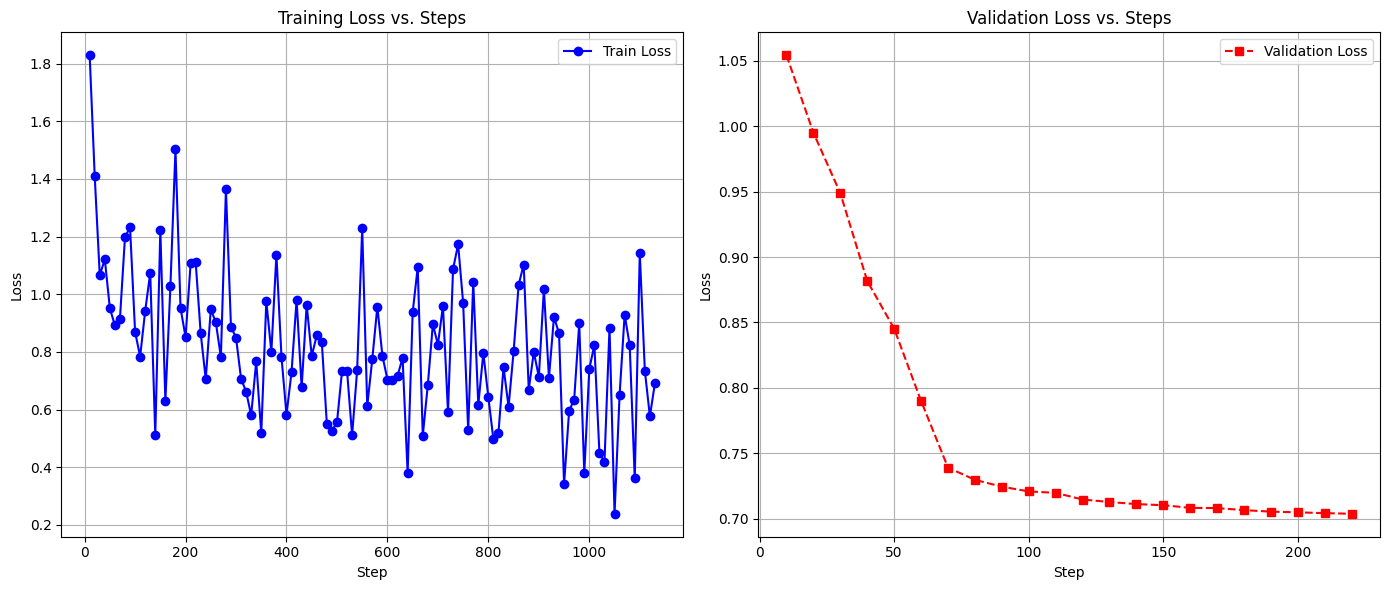

In [ ]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import pandas as pd

# the training loss and validation loss is recorded during running the finetune.py
df = pd.read_csv("/kaggle/working/src/p2/src/training_log.csv")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  
axes[0].plot(df["step"], df["train_loss"], marker="o", color="blue", label="Train Loss")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss vs. Steps")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df["step"], df["val_loss"], marker="s", linestyle="--", color="red", label="Validation Loss")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Loss")
axes[1].set_title("Validation Loss vs. Steps")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("loss_curves_separated.png", dpi=300, bbox_inches='tight')
plt.show()